# $\sigma$-clipping:
The notebooks prior where the errors were first introduced has the odd combination of assuming LIGO sees every event while also putting in a measurement error that roughly depends on how detectable the object is. In the next section, objects where $\frac{\sigma}{\mu}>\sigma_{cut}$ for _either_ $m_1$ or $d_L$ will be removed, as LIGO would likely ignore them anyways. Looking at the line plot of two error functions way above, this will likely remove quite a few of them

Because this relies on the emprical errors associated with measurements, the bootstrap method can't be applied here

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

In [2]:
ms = generate_masses(f=0.5)
dLs = generate_dLs()
zs = dLs_to_zs(dLs)

m_det = ms*(1+zs)

In [3]:
m_dls = m_det/dLs
sigma_dls = sigma_dL(m_dls)
sigma_ms  = sigma_m(m_dls)

In [4]:
sigma_cut = 0.2 ## roughly correponds to SNR of 5


n_events = len(m_det)
n_dLs=10
n_mc = 8
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(dLs)
dL_max = max(dLs)
quant_min = 0.2 #quantile mins and maxs
quant_max = 0.8

In [5]:
m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(dLs, np.linspace(quant_min, quant_max, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

In [6]:
dL_cut = dLs[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]
ms_cut = m_det[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]
sigma_ms_cut = sigma_ms[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]
sigma_dL_cut = sigma_dls[(sigma_dls < sigma_cut) & (sigma_ms < sigma_cut)]

100%|██████████| 8/8 [00:34<00:00,  4.31s/it]


Text(0.5, 1.0, '$\\sigma$-clipping at $\\frac{\\sigma_{max}}{\\mu}=0.2$')

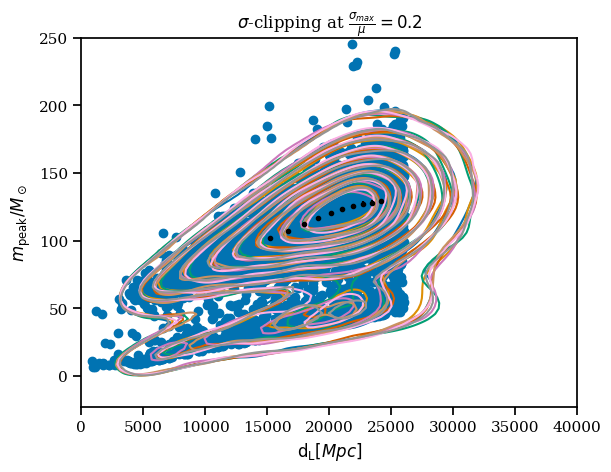

In [7]:
for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(ms_cut), sigma=sigma_ms_cut)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(dL_cut), sigma=sigma_dL_cut)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(dL_cut, ms_cut)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(0, 40000)
plt.ylim(top=250)
plt.title(r"$\sigma$-clipping at $\frac{\sigma_{max}}{\mu}=%.1f$" %(sigma_cut))

In [8]:
print(f"Looks like there's a very hard dL cutoff at {max(dL_cut)} Mpc")

Looks like there's a very hard dL cutoff at 26016.00331797468 Mpc


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.


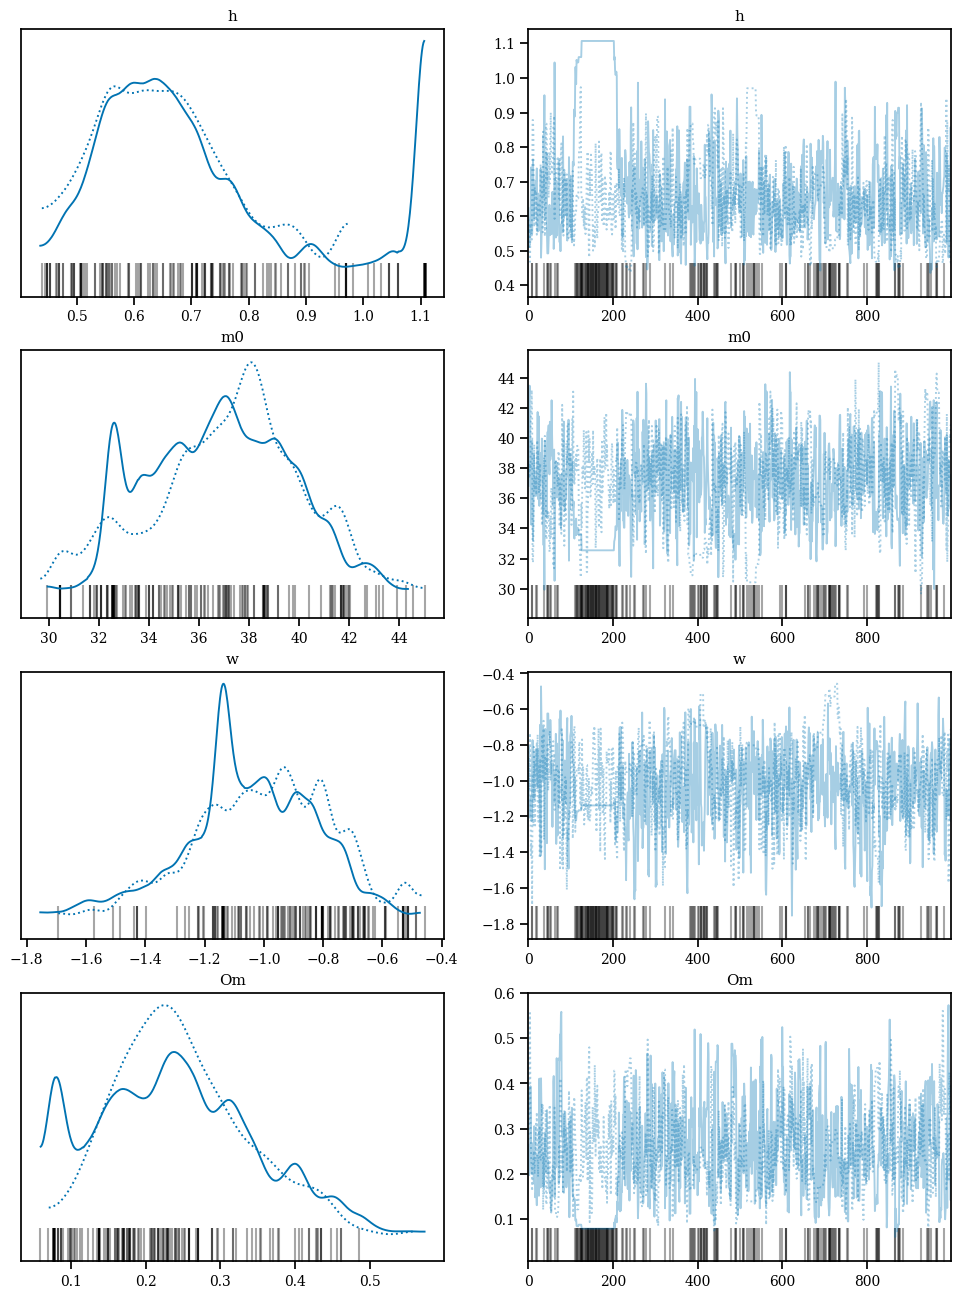

In [9]:
mu_m = np.mean(mpeak_samples, axis=0)
sigmam = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(12, 16))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

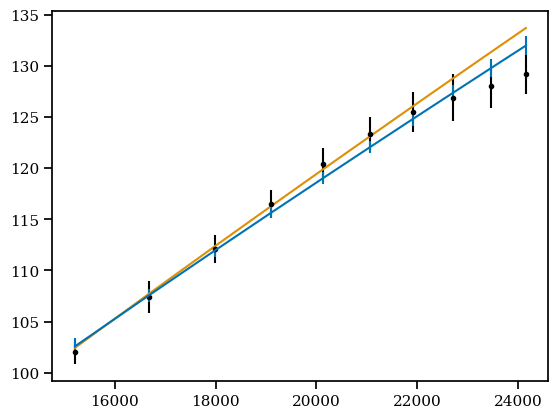

In [10]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']))
plt.plot(dL_cent, 35*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent*u.Mpc).value))

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

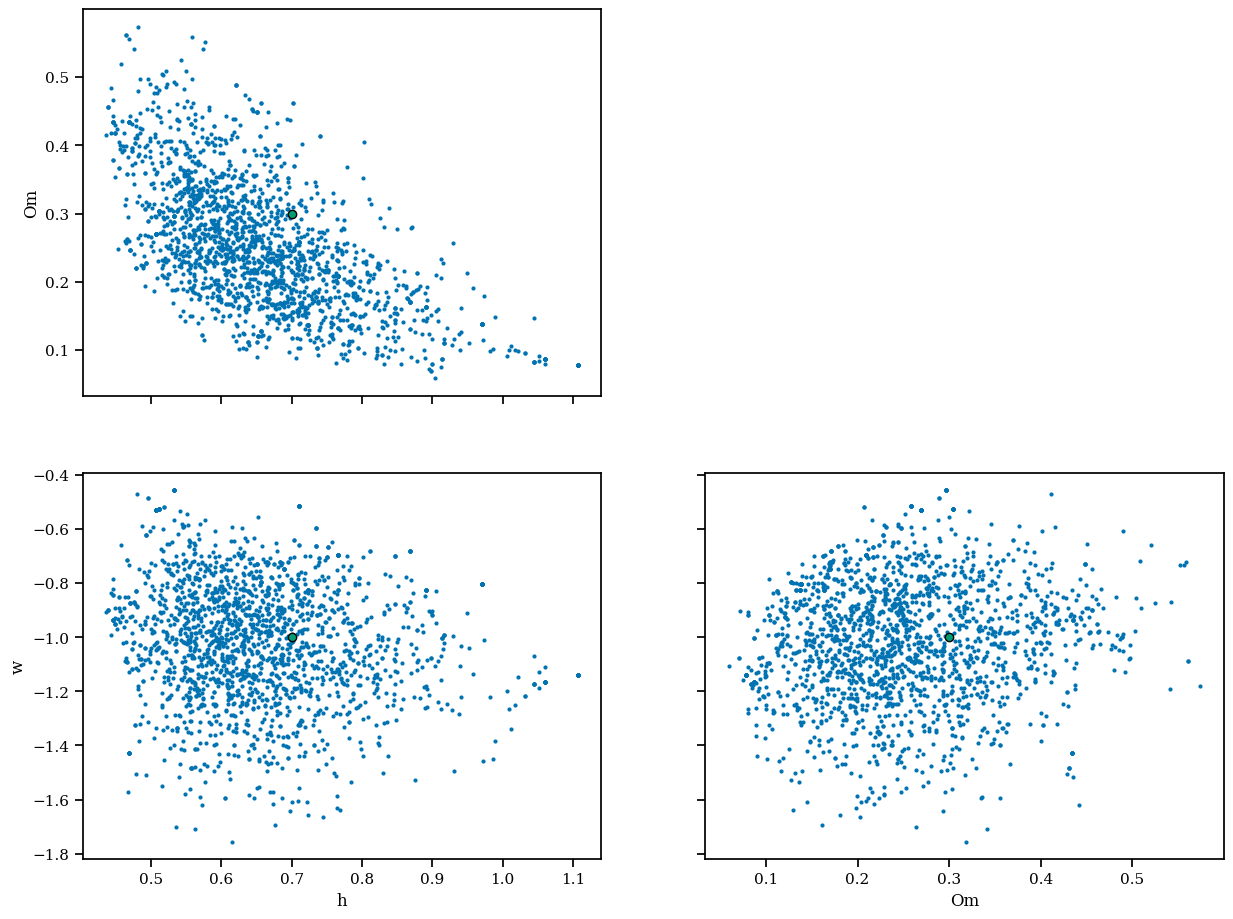

In [11]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})

## Joint $\sigma$ clipping

Now we're going to do a joint sigma clipping that is $SNR^2 = SNR_{dL}^2 + SNR_m^2$ and limit *that* to the cutoff of 5

In [16]:
snr_m = 1/sigma_ms
snr_dLs = 1/sigma_dls
snr_tot = np.sqrt(snr_m**2 + snr_dLs**2)
sigma_tot = 1/snr_tot

In [17]:
dL_cut = dLs[sigma_tot < sigma_cut]
ms_cut = m_det[sigma_tot < sigma_cut]
sigma_ms_cut = sigma_ms[sigma_tot < sigma_cut]
sigma_dL_cut = sigma_dls[sigma_tot < sigma_cut]

100%|██████████| 8/8 [01:03<00:00,  7.96s/it]


Text(0.5, 1.0, '$\\sigma$-clipping at $\\frac{\\sigma_{max}}{\\mu}=0.2$')

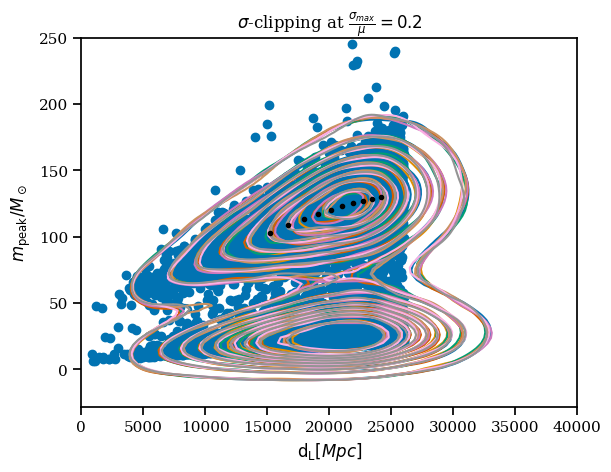

In [18]:
for run in tqdm(range(n_mc)):

    m_det_mc = np.random.lognormal(mean=np.log(ms_cut), sigma=sigma_ms_cut)
    # print(m_det_mc[0])
    d_Ls_mc = np.random.lognormal(mean=np.log(dL_cut), sigma=sigma_dL_cut)


    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(dL_cut, ms_cut)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.xlim(0, 40000)
plt.ylim(top=250)
plt.title(r"$\sigma$-clipping at $\frac{\sigma_{max}}{\mu}=%.1f$" %(sigma_cut))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 47 seconds.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.


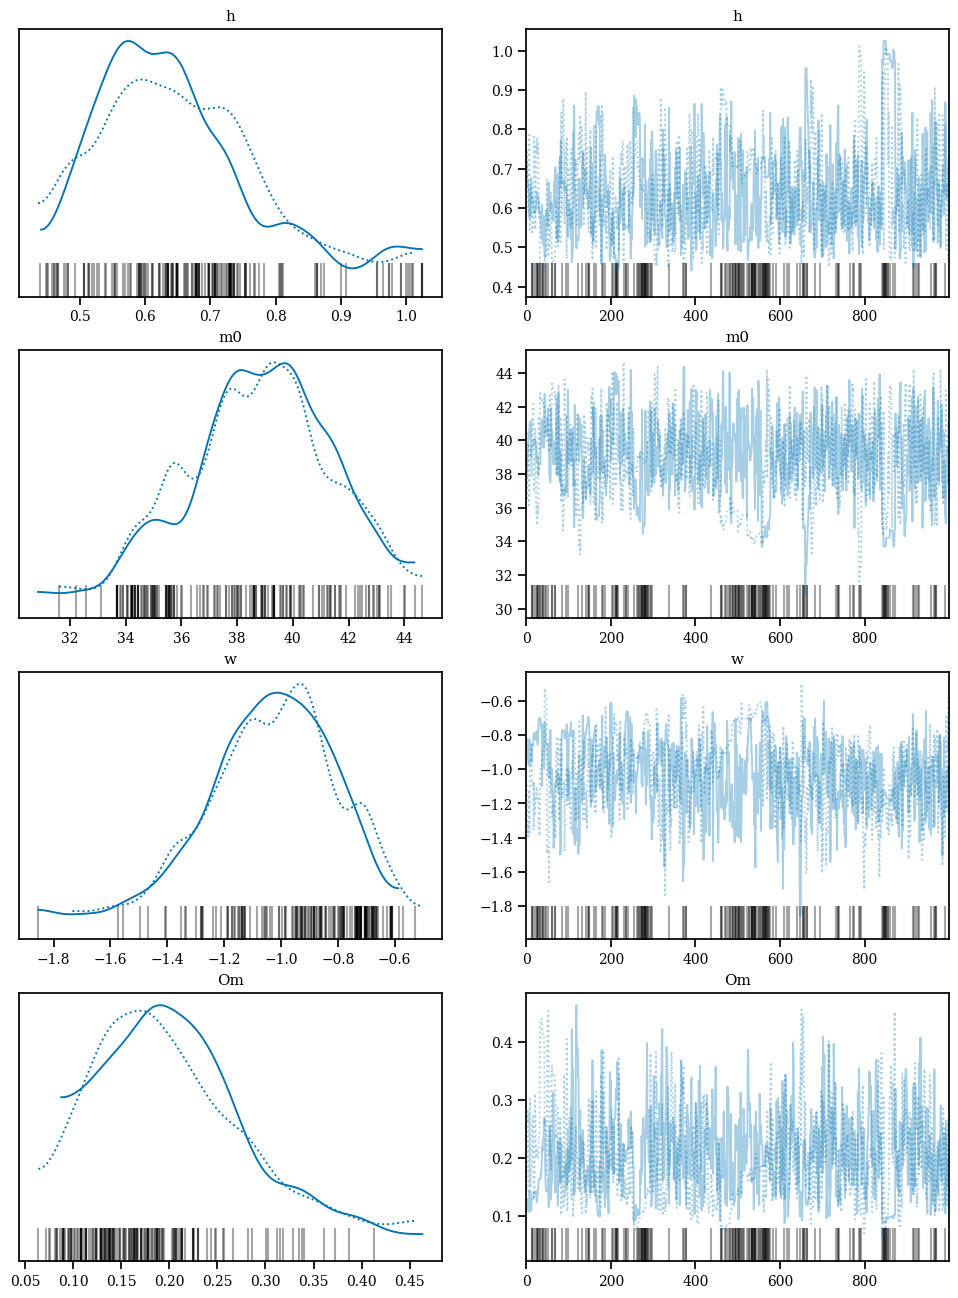

In [19]:
mu_m = np.mean(mpeak_samples, axis=0)
sigmam = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigmam, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(12, 16))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

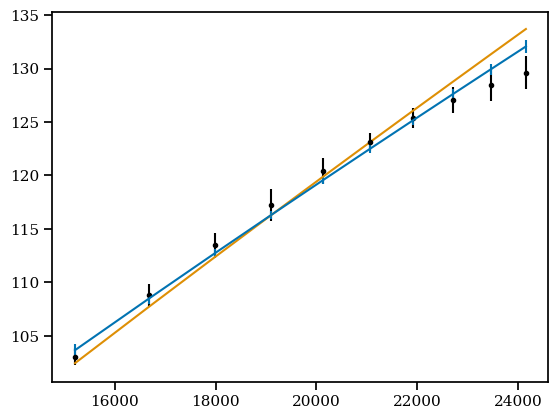

In [20]:
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.errorbar(dL_cent, trace.posterior['m_peak'].mean(dim=['chain', 'draw']), yerr=trace.posterior['m_peak'].std(dim=['chain', 'draw']))
plt.plot(dL_cent, 35*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent*u.Mpc).value))

array([[<AxesSubplot:ylabel='Om'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>]],
      dtype=object)

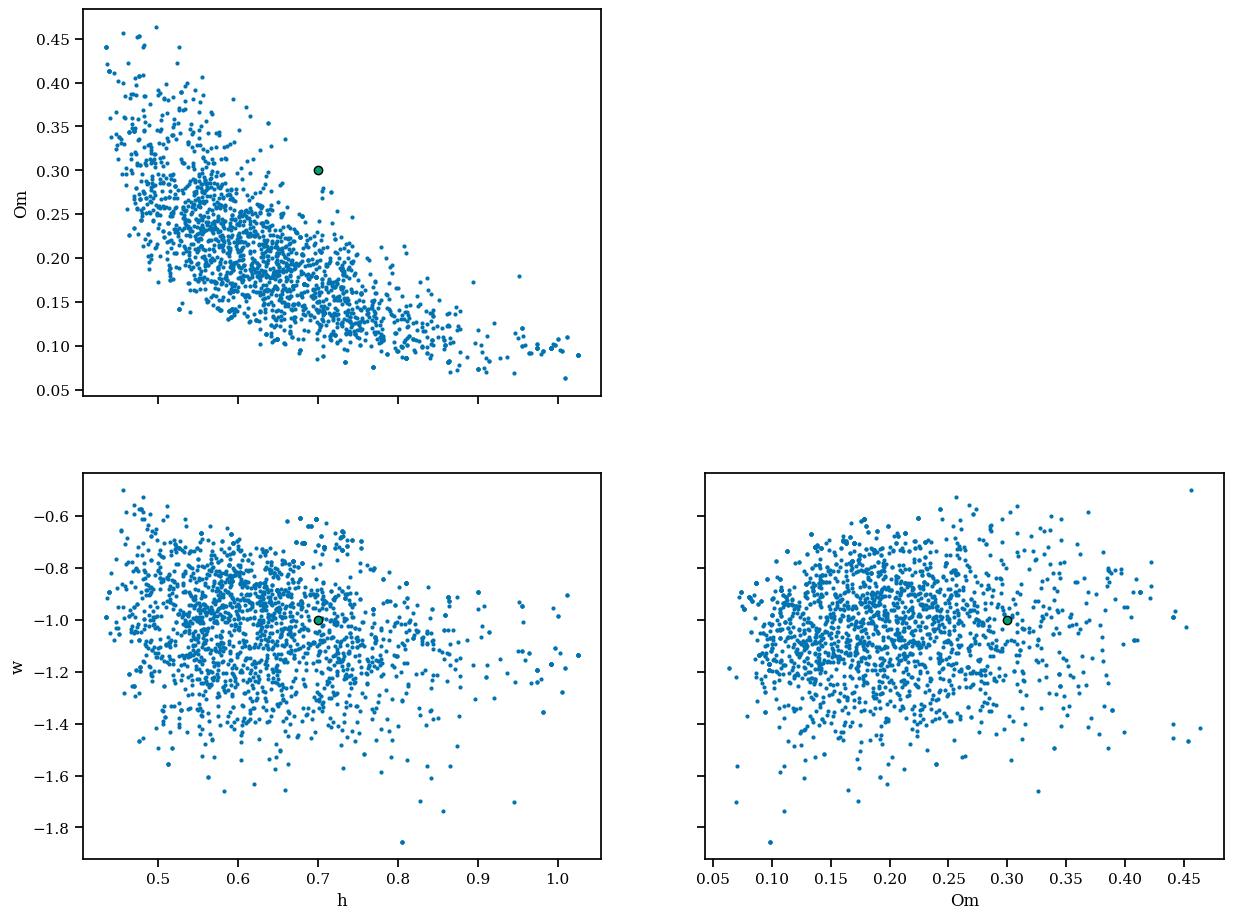

In [21]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], reference_values={'h': 0.7, 'Om':0.3, 'w':-1})